In [1]:
# A bit of setup
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from utils.data_utils import *
from utils.helpers import *
from IPython.display import Image

# Set parameters for matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)     #set default size for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/auto-reload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Loading and Preparing Data

In [2]:
# Load training and testing data
X_train_desc, y_train_desc, X_test_desc, y_test_desc = load_data(num_train=50, num_test=10)
print('X_train: %d' % len(X_train_desc))
print('y_train: %d' % len(y_train_desc))
print('X_test:  %d' % len(X_test_desc))
print('y_test:  %d' % len(y_test_desc))

X_train: 50
y_train: 50
X_test:  10
y_test:  10


In [3]:
# Create a tokenizer
tokenizer = Tokenizer(y_train_desc)
vocab_size = len(tokenizer.dictionary)+1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 564


In [4]:
# Prepare sequences
X1_train, X2_train, y_train = create_sequences(tokenizer, X_train_desc, y_train_desc, vocab_size)
print('X1_train (features): ', X1_train.shape)
print('X2_train (words in): ', X2_train.shape)
print('y_train  (word out):  ', y_train.shape)

X1_train (features):  (2671, 4096)
X2_train (words in):  (2671, 22)
y_train  (word out):   (2671, 564)


## Defining Model

In [9]:
# Define some variables
feature_length = X1_train.shape[1]
max_length = X2_train.shape[1]
embed_size = 256

In [16]:
# Clear old graphs and define a new one
tf.reset_default_graph
graph1 = tf.Graph()
with graph1.as_default():
    # Define placeholders
    X1 = tf.placeholder(tf.float32, [None, feature_length], name='X1')
    X2 = tf.placeholder(tf.int32, [None, max_length], name='X2')
    y  = tf.placeholder(tf.int32,   [None, vocab_size], name='y')

    # Sequence model
    W_embed  = tf.get_variable("word_embeddings", [vocab_size, embed_size])
    X2_embed = tf.nn.embedding_lookup(W_embed, X2)

    mask = tf.concat([tf.zeros([1, 1]),tf.ones([vocab_size - 1, 1])],0)
    mask_embed = tf.nn.embedding_lookup(mask, X2)
    X2_embed = tf.multiply(X2_embed, mask_embed)

    dropout_sm = tf.nn.dropout(X2_embed, 0.5)
    lstm_cell = tf.contrib.rnn.LSTMCell(embed_size)
    lstm_in = tf.transpose(dropout_sm, (1,0,2))
    lstm_out, _ = tf.nn.dynamic_rnn(lstm_cell, lstm_in, dtype=tf.float32, time_major=True)[-1]

    # Feature extractor model
    dropout_fe = tf.nn.dropout(X1, 0.5)
    W_fe = tf.get_variable('W_fe', shape=[feature_length, embed_size])
    b_fe = tf.get_variable('b_fe', shape=embed_size)

    fe_out = tf.nn.relu(tf.matmul(dropout_fe, W_fe) + b_fe)

    # Decoder model
    W_d1 = tf.get_variable('W_d1', shape=[embed_size, embed_size])
    b_d1 = tf.get_variable('b_d1', shape=embed_size)
    W_d2 = tf.get_variable('W_d2', shape=[embed_size, vocab_size])
    b_d2 = tf.get_variable('b_d2', shape=vocab_size)

    d1 = lstm_out + fe_out
    d2 = tf.nn.relu(tf.matmul(d1, W_d1) + b_d1)
    out = tf.matmul(d2, W_d2) + b_d2
    tf.identity(out, name="out")

    # Calculate loss
    total_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out)
    mean_loss = tf.reduce_mean(total_loss)

    # Define optimizer and take a training step
    optimizer = tf.train.AdamOptimizer().minimize(mean_loss)

## Training

Iteration:  0 Current Loss:  6.7960486
Iteration:  50 Current Loss:  2.6440332
Iteration:  100 Current Loss:  1.3429339
Iteration:  150 Current Loss:  0.68116766
Iteration:  200 Current Loss:  0.33687082
Iteration:  250 Current Loss:  0.25962773
Iteration:  300 Current Loss:  0.21178304
Iteration:  350 Current Loss:  0.1967806
Iteration:  400 Current Loss:  0.19568539
Iteration:  450 Current Loss:  0.17834519


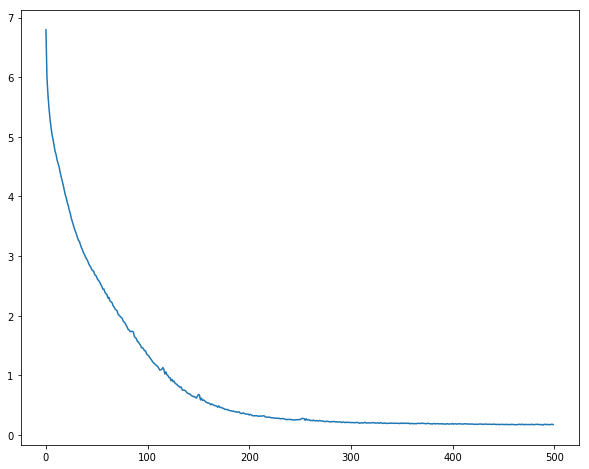

In [17]:
# Run a tensorflow session
with graph1.as_default():
    saver = tf.train.Saver(save_relative_paths=True)
    with tf.Session() as sess1:
        with tf.device("/cpu:0"):
            loss_history = []
            tf.global_variables_initializer().run()
            for iter in range(500):
                _, curr_loss = sess1.run([optimizer, mean_loss], feed_dict={X1: X1_train, X2: X2_train, y: y_train})
                loss_history.append(curr_loss)
                if iter % 50 == 0:
                    print('Iteration: ', iter, 'Current Loss: ', curr_loss)
        saver.save(sess1, 'trained_models/image_captioning_f8k')
        #saver.save(sess, "/tmp/model.ckpt")
        plt.plot(loss_history)
        plt.show()

## Testing

In [5]:
# load and prepare(preprocess) a photograph for captioning
def preprocess_image_for_captioning(filename):
    graph2 = tf.Graph()
    with graph2.as_default():
        with tf.Session() as sess2:
            features = extract_features_from_photo(file_name)
            features = np.array(features)
    return features

In [6]:
# generate a description for an image
def generate_desc(session, dictionary, photo, max_length):
    # create a reverse dictionary for converting numbers back to words
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))    
    # seed the generation process
    in_text = 'startseq'
    sequence = [dictionary[in_text]]
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # pad input
        padded_input = pad_sequences(sequence, max_len=max_length)
        # convert input to numpy array and reshape
        X2_in = np.reshape(np.array(padded_input),[1,-1])
        # predict next word
        yhat = session.run('out:0', feed_dict={'X1:0': photo, 'X2:0': X2_in})
        # convert probability to integer
        yhat = np.argmax(yhat)
        # stop if we cannot map the word
        if yhat >= len(dictionary):
            in_text += ' ' + 'UNKNOWN'
            break
        # append as input for generating the next word
        sequence.extend([yhat])
        # map integer to word and store
        in_text += ' ' + reverse_dictionary[yhat]
        # stop if we predict the end of the sequence
        if yhat == dictionary['endseq']:
            break
    return in_text

In [11]:
def caption_it(file_name):
    features = preprocess_image_for_captioning(file_name)
    graph3 = tf.Graph()
    with graph3.as_default():
        imported_meta = tf.train.import_meta_graph('trained_models/image_captioning_f8k.meta')
        # generate description
        with tf.Session() as sess3:
            imported_meta.restore(sess3, tf.train.latest_checkpoint('./trained_models'))
            description = generate_desc(sess3, tokenizer.dictionary, features, max_length)
    return description
    

INFO:tensorflow:Restoring parameters from ./trained_models/image_captioning_f8k
startseq black dog chasing brown dog through snow endseq


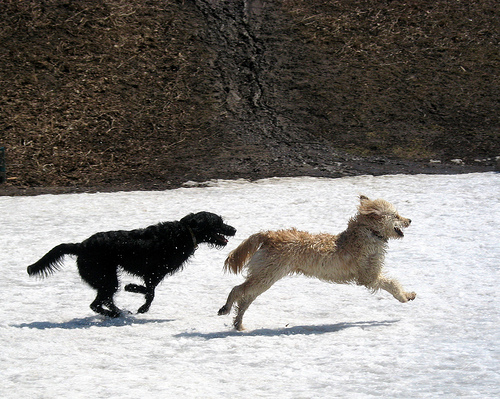

In [16]:
# Picture from training set
file_name = 'utils/data/Flickr8k_Dataset/2513260012_03d33305cf.jpg'
# get captions
captions = caption_it(file_name)
print(captions)
# show photo
Image(file_name)


INFO:tensorflow:Restoring parameters from ./trained_models/image_captioning_f8k
startseq the large dog jumping in the air and white and wall endseq


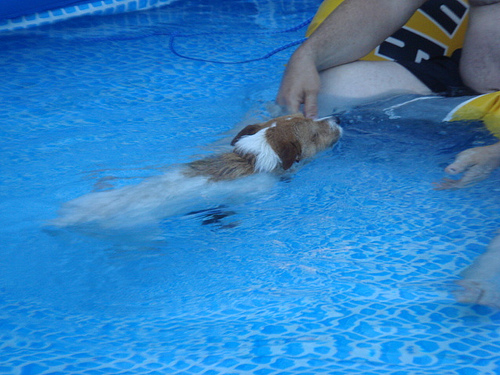

In [15]:
# Picture from testing set
file_name = 'utils/data/Flickr8k_Dataset/2677656448_6b7e7702af.jpg'
# get captions
captions = caption_it(file_name)
print(captions)
# show photo
Image(file_name)